In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(12046)

In [2]:
# 准备数据
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# 将数据划分成训练集、验证集、测试集
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
len(train_set), len(val_set), len(test_set)

(50000, 10000, 10000)

In [3]:
x, y = dataset[21]
x.shape

torch.Size([1, 28, 28])

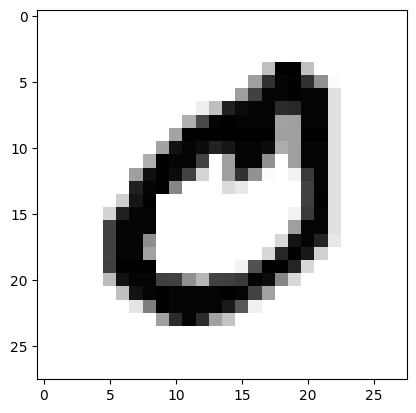

In [4]:
plt.imshow(x.squeeze(0).numpy(), cmap=plt.cm.binary)

In [5]:
# 构建数据读取器
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = DataLoader(val_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=True)

In [6]:
# 获取一个批量的数据
x, y = next(iter(train_loader))
x.shape, y.shape, x.view(x.shape[0], -1).shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]), torch.Size([500, 784]))

In [7]:
# 两种常见实现方式
## 自由度更大的实现方式
class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784, 30)
    self.hidden2 = nn.Linear(30, 20)
    self.out = nn.Linear(20, 10)
  
  def forward(self, X):
    '''
    多层感知器的前向传播
    参数
    ____
    x: torch.FloatTensor, 形状为(B, 784)，其中B表示批量数据的大小
    '''
    x = F.sigmoid(self.hidden1(x))
    x = F.sigmoid(self.hidden2(x))
    x = self.out(x)
    return x
  
model = MLP()

## 更简洁的实现方式
model = nn.Sequential(
  nn.Linear(784, 30), nn.Sigmoid(),
  nn.Linear(30, 20), nn.Sigmoid(),
  nn.Linear(20, 10)
)

In [8]:
eval_iters = 10

def estimate_loss(model):
  re = {}
  # 将模型切换为评估模式
  model.eval()
  re['train'] = _loss(model, train_loader)
  re['val'] = _loss(model, val_loader)
  re['test'] = _loss(model, test_loader)
  # 将模型切换为训练模式
  model.train()
  return re

@torch.no_grad()
def _loss(model, dataloader):
  # 估计模型效果
  loss = []
  acc = []
  data_iter = iter(dataloader)
  for t in range(eval_iters):
    inputs, labels = next(data_iter)
    # inputs: (500, 1, 28, 28)
    # labels: (500)
    B, C, H, W = inputs.shape
    logits = model(inputs.view(B, -1))
    loss.append(F.cross_entropy(logits, labels))
    # preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
    preds = torch.argmax(logits, dim=-1)
    acc.append((preds == labels).sum() / B)
  re = {
    'loss': torch.tensor(loss).mean().item(),
    'acc': torch.tensor(acc).mean().item()
  }
  return re

运行结果大概是

```
{'train': {'loss': 2.3977837562561035, 'acc': 0.10039999336004257},
 'val': {'loss': 2.40299916267395, 'acc': 0.1095999926328659},
 'test': {'loss': 2.3904480934143066, 'acc': 0.10520000755786896}}
```

这里符合预期，10个数，随机选择概率是10%

In [9]:
estimate_loss(model)

{'train': {'loss': 2.3977837562561035, 'acc': 0.10039999336004257},
 'val': {'loss': 2.40299916267395, 'acc': 0.1095999926328659},
 'test': {'loss': 2.3904480934143066, 'acc': 0.10520000755786896}}

In [10]:
def train_model(model, optimizer, epochs=10, penalty=False):
  lossi = []
  for e in range(epochs):
    for data in train_loader:
      inputs, labels = data
      B, C, H, W = inputs.shape
      logits = model(inputs.view(B, -1))
      loss = F.cross_entropy(logits, labels)
      lossi.append(loss.item())
      if penalty:
        w = torch.cat([p.view(-1) for p in model.parameters()])
        loss += 0.001 * w.abs().sum() + 0.002 * w.square().sum()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    stats = estimate_loss(model)
    train_loss = f'{stats["train"]["loss"]:.3f}'
    val_loss = f'{stats["val"]["loss"]:.3f}'
    test_loss = f'{stats["test"]["loss"]:.3f}'
    print(f'epoch {e} train {train_loss} val {val_loss} test {test_loss}')
  return lossi


In [11]:
loss = {}

In [12]:
model = nn.Sequential(
  nn.Linear(784, 30), nn.Sigmoid(),
  nn.Linear(30, 20), nn.Sigmoid(),
  nn.Linear(20, 10)
)

loss['mlp'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.309 val 2.307 test 2.309
epoch 1 train 2.302 val 2.304 test 2.303
epoch 2 train 2.301 val 2.300 test 2.299
epoch 3 train 2.299 val 2.299 test 2.300
epoch 4 train 2.298 val 2.299 test 2.297
epoch 5 train 2.299 val 2.299 test 2.297
epoch 6 train 2.298 val 2.299 test 2.297
epoch 7 train 2.295 val 2.297 test 2.296
epoch 8 train 2.296 val 2.298 test 2.296
epoch 9 train 2.295 val 2.295 test 2.296


### ReLU

In [13]:
model = nn.Sequential(
  nn.Linear(784, 30), nn.ReLU(),
  nn.Linear(30, 20), nn.ReLU(),
  nn.Linear(20, 10)
)

loss['mlp_relu'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.280 val 2.280 test 2.279
epoch 1 train 2.246 val 2.243 test 2.243
epoch 2 train 2.190 val 2.189 test 2.187
epoch 3 train 2.099 val 2.094 test 2.090
epoch 4 train 1.956 val 1.951 test 1.950
epoch 5 train 1.769 val 1.756 test 1.751
epoch 6 train 1.522 val 1.524 test 1.514
epoch 7 train 1.293 val 1.297 test 1.274
epoch 8 train 1.100 val 1.102 test 1.093
epoch 9 train 0.977 val 0.961 test 0.951


### 归一化

In [14]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 1.553 val 1.556 test 1.553
epoch 1 train 1.102 val 1.118 test 1.104
epoch 2 train 0.818 val 0.806 test 0.790
epoch 3 train 0.632 val 0.604 test 0.597
epoch 4 train 0.499 val 0.487 test 0.479
epoch 5 train 0.410 val 0.418 test 0.416
epoch 6 train 0.353 val 0.366 test 0.361
epoch 7 train 0.321 val 0.323 test 0.315
epoch 8 train 0.278 val 0.306 test 0.302
epoch 9 train 0.267 val 0.285 test 0.265


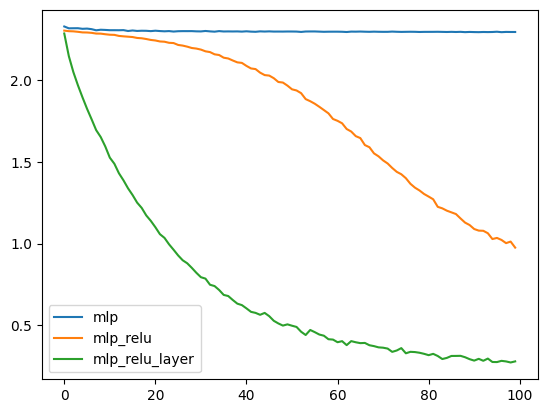

In [15]:
for i in ['mlp', 'mlp_relu', 'mlp_relu_layer']:
  plt.plot(torch.tensor(loss[i]).view(-1, 10).mean(dim=-1), label=i)
plt.legend()
plt.show()

In [16]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

# 增加epochs，模型过拟合
loss['mlp_relu_layer'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.200 val 0.210 test 0.204
epoch 1 train 0.148 val 0.173 test 0.190
epoch 2 train 0.113 val 0.152 test 0.157
epoch 3 train 0.101 val 0.149 test 0.129
epoch 4 train 0.085 val 0.138 test 0.132
epoch 5 train 0.074 val 0.125 test 0.112
epoch 6 train 0.087 val 0.148 test 0.141
epoch 7 train 0.055 val 0.141 test 0.131
epoch 8 train 0.053 val 0.129 test 0.102
epoch 9 train 0.054 val 0.119 test 0.108
epoch 10 train 0.049 val 0.134 test 0.120
epoch 11 train 0.037 val 0.143 test 0.121
epoch 12 train 0.049 val 0.131 test 0.123
epoch 13 train 0.048 val 0.132 test 0.127
epoch 14 train 0.042 val 0.133 test 0.126
epoch 15 train 0.030 val 0.118 test 0.114
epoch 16 train 0.024 val 0.123 test 0.125
epoch 17 train 0.026 val 0.124 test 0.116
epoch 18 train 0.025 val 0.103 test 0.132
epoch 19 train 0.031 val 0.139 test 0.139


### Dropout

In [17]:
m = nn.Dropout(0.5)
x = torch.randn(5, requires_grad=True)

In [18]:
x

tensor([-1.3283, -1.9110, -0.5863,  1.6094,  0.3471], requires_grad=True)

In [19]:
m.train()
l = m(x)
l.sum().backward()
l, x.grad

(tensor([-2.6567, -3.8221, -0.0000,  0.0000,  0.6942], grad_fn=<MulBackward0>),
 tensor([2., 2., 0., 0., 2.]))

In [20]:
m.eval()
m(x)

tensor([-1.3283, -1.9110, -0.5863,  1.6094,  0.3471], requires_grad=True)

In [21]:
m.training

False

In [22]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer_dropout'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.250 val 0.257 test 0.253
epoch 1 train 0.205 val 0.202 test 0.210
epoch 2 train 0.169 val 0.198 test 0.203
epoch 3 train 0.154 val 0.185 test 0.181
epoch 4 train 0.148 val 0.166 test 0.192
epoch 5 train 0.137 val 0.172 test 0.177
epoch 6 train 0.139 val 0.170 test 0.177
epoch 7 train 0.122 val 0.181 test 0.168
epoch 8 train 0.110 val 0.164 test 0.163
epoch 9 train 0.142 val 0.166 test 0.169
epoch 10 train 0.129 val 0.162 test 0.172
epoch 11 train 0.102 val 0.153 test 0.165
epoch 12 train 0.134 val 0.166 test 0.172
epoch 13 train 0.095 val 0.160 test 0.151
epoch 14 train 0.126 val 0.168 test 0.149
epoch 15 train 0.102 val 0.144 test 0.144
epoch 16 train 0.103 val 0.152 test 0.165
epoch 17 train 0.108 val 0.174 test 0.160
epoch 18 train 0.099 val 0.160 test 0.160
epoch 19 train 0.103 val 0.155 test 0.166


### 惩罚项

In [23]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

_ = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20, penalty=True)

epoch 0 train 0.245 val 0.273 test 0.272
epoch 1 train 0.247 val 0.248 test 0.249
epoch 2 train 0.210 val 0.243 test 0.232
epoch 3 train 0.202 val 0.221 test 0.200
epoch 4 train 0.234 val 0.234 test 0.232
epoch 5 train 0.218 val 0.213 test 0.212
epoch 6 train 0.240 val 0.220 test 0.224
epoch 7 train 0.216 val 0.253 test 0.226
epoch 8 train 0.206 val 0.205 test 0.197
epoch 9 train 0.178 val 0.190 test 0.180
epoch 10 train 0.186 val 0.186 test 0.184
epoch 11 train 0.189 val 0.204 test 0.196
epoch 12 train 0.184 val 0.215 test 0.188
epoch 13 train 0.197 val 0.208 test 0.218
epoch 14 train 0.195 val 0.212 test 0.202
epoch 15 train 0.184 val 0.197 test 0.205
epoch 16 train 0.220 val 0.232 test 0.217
epoch 17 train 0.179 val 0.202 test 0.196
epoch 18 train 0.213 val 0.226 test 0.220
epoch 19 train 0.214 val 0.217 test 0.199


In [24]:
estimate_loss(model)

{'train': {'loss': 0.20386986434459686, 'acc': 0.9462000131607056},
 'val': {'loss': 0.20506790280342102, 'acc': 0.9427999258041382},
 'test': {'loss': 0.19779081642627716, 'acc': 0.9431999921798706}}